## Logistic Regression on Copy Number Variation and RNAseq

In [1]:
import pandas as pd

In [2]:
#Import Data
y = pd.read_table('/Users/a.su/Documents/Cancer_RNAseq_CNV/CancerTypes_y.txt', sep = '\t', header = None)
x_cnv = pd.read_table('/Users/a.su/Documents/Cancer_RNAseq_CNV/CNV_processed.txt', sep = '\t', header = 0)
x_rna = pd.read_table('/Users/a.su/Documents/Cancer_RNAseq_CNV/RNAseq_processed.txt', sep = '\t', header = 0)

In [3]:
# Remove GeneID Column
x_cnv = x_cnv.drop('GeneID', axis = 1)
x_rna = x_rna.drop('GeneID', axis = 1)
# Transpose
x_cnv = x_cnv.transpose()
x_rna = x_rna.transpose()
print('x_cnv shape is:', x_cnv.shape)
print('x_rna shape is:', x_rna.shape)
print('y shape is:', y.shape)

x_cnv shape is: (668, 26094)
x_rna shape is: (668, 26094)
y shape is: (668, 1)


#### DropNa from CNV data

In [4]:
#Merge CNV x and y data
cnv = x_cnv.reset_index(drop = True)
cnv['y'] = y[0]

#Drop NaN
cnv_clean = cnv.dropna('index')
print(cnv_clean.shape)

#Unmerge CNV x and y data
y_cnv_clean = cnv_clean['y']
x_cnv_clean = cnv_clean.drop(['y'], axis = 1)

(542, 26095)


#### Impute CNV data

In [5]:
import numpy as np
from sklearn.impute import SimpleImputer
impute_median = SimpleImputer(strategy = 'median')

#Impute 
y_cnv_imputed = cnv['y']
x_cnv_imputed = cnv.drop(['y'], axis = 1)
x_cnv_imputed = impute_median.fit_transform(x_cnv_imputed)

#Check for NaN values
np.isnan(x_cnv_imputed).all()

False

In [6]:
x_rna[798].sum()

0.0

In [7]:
x_rna.std().value_counts()[0]

111

In [8]:
x_rna.sum().value_counts()[0]

111

#### Scale RNASeq and CNV data

In [9]:
def zscore(x):
    if x.std()==0:
        return x
    else:
        return (x-x.mean())/ x.std()
    
x_cnv_imputed = pd.DataFrame(x_cnv_imputed)

In [10]:
x_rna_processed = x_rna.transform(zscore)
y_rna_processed = y
x_cnv_processed = x_cnv_imputed.transform(zscore)
y_cnv_processed = y

In [11]:
#Visualise
x_rna_processed[np.random.choice(x_rna_processed.columns.values, size = 10, replace = False)].describe()

,20167,13722,1851,20881,22115,2616,24483,17158,9159,12455
count,6.680000e+02,6.680000e+02,6.680000e+02,6.680000e+02,6.680000e+02,6.680000e+02,6.680000e+02,6.680000e+02,6.680000e+02,6.680000e+02
mean,-2.629301e-16,2.869461e-16,3.154600e-16,-9.938823e-17,2.197178e-16,5.168853e-17,3.488145e-17,6.305668e-16,5.308046e-17,4.613949e-16
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.951823e+00,-5.383599e-01,-2.905367e-01,-8.464251e-01,-1.674765e-01,-2.783002e-01,-2.635522e-01,-3.203946e-01,-1.222212e-01,-2.633668e-01
25%,-7.284997e-01,-3.261010e-01,-2.843474e-01,-4.757437e-01,-1.674765e-01,-2.783002e-01,-2.635522e-01,-3.191388e-01,-9.936017e-02,-2.542393e-01
50%,-1.629567e-01,-1.201987e-01,-2.644411e-01,-2.406168e-01,-1.674765e-01,-2.783002e-01,-2.258160e-01,-2.704277e-01,-8.409800e-02,-2.370407e-01
75%,6.530044e-01,9.866376e-02,-1.833225e-01,1.549925e-01,-1.674765e-01,-2.783002e-01,-9.827778e-02,-8.017529e-03,-5.816563e-02,-1.294160e-01
max,4.601089e+00,2.045431e+01,1.014046e+01,1.709777e+01,1.036064e+01,9.988732e+00,1.314159e+01,1.417645e+01,2.401772e+01,1.993918e+01


In [12]:
x_cnv_processed[np.random.choice(x_cnv_processed.columns.values, size = 10, replace = False)].describe()

,17514,2218,6406,19231,17600,9845,9865,2760,25251,25653
count,668.000000,6.680000e+02,6.680000e+02,6.680000e+02,6.680000e+02,6.680000e+02,6.680000e+02,6.680000e+02,6.680000e+02,6.680000e+02
mean,0.000000,-2.601877e-16,-4.028713e-16,3.294845e-16,-7.977650e-18,-4.296297e-16,2.720711e-16,-1.030447e-17,-2.394292e-15,-2.037230e-15
std,1.000000,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-3.350723,-2.730845e+00,-3.371695e+00,-3.540759e+00,-3.229626e+00,-2.640640e+00,-2.424162e+00,-3.227621e+00,-1.607544e+00,-1.393965e+00
25%,-0.646967,-5.951384e-01,-6.712804e-01,-6.471260e-01,-6.690610e-01,-5.516521e-01,-5.678252e-01,-5.805555e-01,-7.253051e-01,-7.654442e-01
50%,-0.088708,-1.115878e-01,1.587067e-02,-9.453480e-02,-9.478632e-02,-1.534077e-01,-1.355019e-01,-1.323432e-01,-2.843400e-01,-3.247902e-01
75%,0.580878,5.241901e-01,5.776923e-01,6.451988e-01,5.932435e-01,5.616168e-01,5.438505e-01,5.491761e-01,3.970244e-01,4.908609e-01
max,3.776404,4.603302e+00,4.614150e+00,3.399421e+00,3.330405e+00,5.611250e+00,8.916026e+00,4.207141e+00,5.193424e+00,3.727471e+00


In [13]:
#Check for NaN values
print(x_rna_processed.isnull().any().any())
print(x_cnv_processed.isnull().any().any())

False
False


### Logistic Regression on CNV and RNAseq Individually (Unprocessed Data)

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

In [15]:
#Split data into training and test sets
x_cnv_train, x_cnv_test, y_cnv_train, y_cnv_test = train_test_split(x_cnv_clean, y_cnv_clean.values.flatten(), test_size = 0.25, random_state = 0)
x_rna_train, x_rna_test, y_rna_train, y_rna_test = train_test_split(x_rna, y.values.flatten(), test_size = 0.25, random_state = 0)

CNV_regression = LogisticRegression(penalty = 'l1', solver = 'liblinear')
RNA_regression = LogisticRegression(penalty = 'l1', solver = 'liblinear')

#Fit train set
CNV_regression.fit(x_cnv_train, y_cnv_train)
RNA_regression.fit(x_rna_train, y_rna_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

In [16]:
print('CNV accuracy:', CNV_regression.score(x_cnv_test, y_cnv_test))
print('RNA accurary:', RNA_regression.score(x_rna_test, y_rna_test))

CNV accuracy: 0.7132352941176471
RNA accurary: 0.7844311377245509


### Logistic Regression on CNV and RNAseq Individually (Processed Data)
Processing include imputation and scaling

In [17]:
#Split data into training and test sets
x_cnv_processed_train, x_cnv_processed_test, y_cnv_processed_train, y_cnv_processed_test = train_test_split(
    x_cnv_processed, y_cnv_processed.values.flatten(), test_size = 0.25, random_state = 0)
x_rna_processed_train, x_rna_processed_test, y_rna_processed_train, y_rna_processed_test = train_test_split(
    x_rna_processed, y_rna_processed.values.flatten(), test_size = 0.25, random_state = 0)

CNV_processed_regression = LogisticRegression(penalty = 'l1', solver = 'liblinear')
RNA_processed_regression = LogisticRegression(penalty = 'l1', solver = 'liblinear')

#Fit train set
CNV_processed_regression.fit(x_cnv_processed_train, y_cnv_processed_train)
RNA_processed_regression.fit(x_rna_processed_train, y_rna_processed_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

In [18]:
print('CNV processed accuracy:', CNV_processed_regression.score(x_cnv_processed_test, y_cnv_processed_test))
print('RNA processed accurary:', RNA_processed_regression.score(x_rna_processed_test, y_rna_processed_test))

CNV processed accuracy: 0.7305389221556886
RNA processed accurary: 0.8143712574850299


### Logistic Regression on combined CNV and RNAseq data (processed)

In [20]:
x_combined = pd.concat([x_cnv_processed.reset_index(drop = True), x_rna_processed.reset_index(drop = True)] , axis = 1)
y_combined = y[0]
x_combined.shape

(668, 52188)

In [26]:
#Visualise
x_combined[np.random.choice(x_combined.columns.values, size = 5, replace = False)].describe()

,1615,1615,10777,10777,24346,24346,5087,5087,14471,14471
count,6.680000e+02,6.680000e+02,6.680000e+02,6.680000e+02,6.680000e+02,6.680000e+02,6.680000e+02,6.680000e+02,6.680000e+02,6.680000e+02
mean,-6.156087e-16,-1.906326e-16,-4.720110e-16,1.014242e-16,-1.998568e-17,1.804112e-16,1.525726e-16,6.982937e-16,-1.223240e-16,5.630061e-17
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-2.188317e+00,-3.089328e-01,-2.680577e+00,-2.013275e-01,-3.562418e+00,-1.250397e+00,-3.455665e+00,-1.328679e+00,-3.850974e+00,-5.081912e-01
25%,-6.721086e-01,-3.089328e-01,-6.638914e-01,-2.013275e-01,-6.024707e-01,-6.205395e-01,-5.975352e-01,-6.223773e-01,-6.424703e-01,-5.081912e-01
50%,-1.958949e-01,-3.089328e-01,5.822450e-02,-1.999130e-01,-1.206120e-02,-1.727304e-01,-1.517362e-01,-1.597236e-01,-1.103181e-01,-5.081912e-01
75%,5.824420e-01,-3.089328e-01,5.747847e-01,-1.708022e-01,5.530157e-01,4.176557e-01,5.355811e-01,3.796574e-01,6.139116e-01,1.526267e-01
max,4.406788e+00,8.497962e+00,3.444999e+00,1.509500e+01,3.086978e+00,7.751441e+00,2.850147e+00,6.157041e+00,4.228769e+00,9.630502e+00


In [32]:
#Split data into training and test sets
x_combined_train, x_combined_test, y_combined_train, y_combined_test = train_test_split(
    x_combined, y_combined.values.flatten(), test_size = 0.25, random_state = 0)

Combined_regression = LogisticRegression(penalty = 'l1',solver = 'liblinear', random_state = 0)
Combined_regression.fit(x_combined_train, y_combined_train)
Combined_regression.score(x_combined_test, y_combined_test)

0.8562874251497006

In [33]:
combined_prediction = Combined_regression.predict(x_combined_test)

#### Precision Recall Curve

In [34]:
from sklearn.metrics import precision_recall_curve, confusion_matrix, roc_curve
import matplotlib.pyplot as plt
from sklearn.utils.fixes import signature

In [35]:
precision, recall, _ = precision_recall_curve(y_combined_test, combined_prediction)

In [36]:
precision_recall = list(zip(precision,recall))

In [37]:
precision_recall

[(0.31736526946107785, 1.0),
 (0.7735849056603774, 0.7735849056603774),
 (1.0, 0.0)]

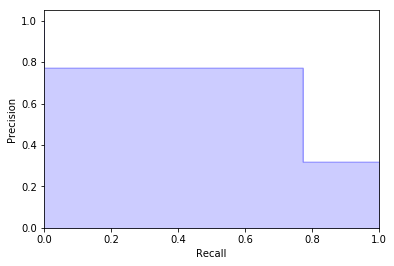

In [38]:
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.show()

#### ROC Curve

In [40]:
fpr, tpr, thresholds = roc_curve(y_combined_test, combined_prediction)

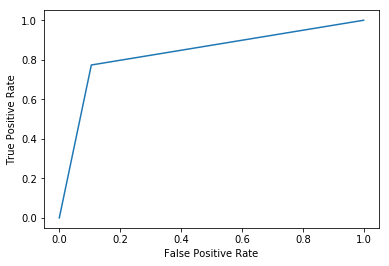

In [42]:
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

#### Confusion Matrix

In [45]:
confusion_matrix(y_combined_test, combined_prediction)

array([[102,  12],
       [ 12,  41]])

In [47]:
import seaborn as sns

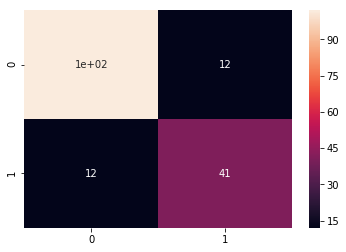

In [49]:
sns.heatmap(confusion_matrix(y_combined_test, combined_prediction), annot = True)

#### Grid Search

In [113]:
from sklearn.model_selection import GridSearchCV

In [164]:
#c_values = [0.001, 0.01, 1, 10, 100, 1000]
c_values = [1,5,6,7,8,9,10,11,12,13,14,15,20,50]
parameters = {'C': c_values, 'penalty': ['l1','l2'], 'solver': ['liblinear']}
clf = GridSearchCV(cv = 3, estimator = Combined_regression, param_grid = parameters)

In [165]:
clf.fit(x_combined_train, y_combined_train)

/Users/a.su/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': [1, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 20, 50], 'penalty': ['l1', 'l2'], 'solver': ['liblinear']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [166]:
clf.best_score_

0.812375249500998

In [167]:
clf.score(x_combined_test, y_combined_test)

0.8203592814371258

In [168]:
clf.best_params_

{'C': 12, 'penalty': 'l1', 'solver': 'liblinear'}

#### Elastic Net

In [119]:
from sklearn.linear_model import SGDClassifier

In [137]:
SGD = SGDClassifier(alpha = 0.1, epsilon = 0.01, loss = 'log', max_iter = 100, penalty = 'elasticnet')

In [138]:
SGD.fit(x_combined_train, y_combined_train)

SGDClassifier(alpha=0.1, average=False, class_weight=None,
       early_stopping=True, epsilon=0.01, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=100,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='elasticnet',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.25, verbose=0, warm_start=False)

In [139]:
SGD.score(x_combined_test, y_combined_test)

0.7664670658682635

In [143]:
SGD_parameters = {'alpha': [0.001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000], 'penalty':['elasticnet'], 
                  'epsilon': [0.001, 0.01, 0.1, 1, 10]}

In [144]:
SGD_search = GridSearchCV(estimator = SGD, param_grid= SGD_parameters)

In [145]:
SGD_search.fit(x_combined_train, y_combined_train)

/Users/a.su/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/Users/a.su/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=1000,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=0.001,
       validation_fraction=0.1, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'alpha': [0.001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000], 'penalty': ['elasticnet'], 'epsilon': [0.001, 0.01, 0.1, 1, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [146]:
SGD_search.score(x_combined_test, y_combined_test)

0.7941176470588235

In [147]:
SGD_search.best_params_

{'alpha': 0.1, 'epsilon': 0.01, 'penalty': 'elasticnet'}